(validation:validation_experimental_data)=
# Napari-stress validation

This notebook focuses on the validation of the napari-stress implementation of the legacy code from Gross et al. ({cite}`gross2021stress`). It uses the original dataset that was used in the analysis and compares each result to the original results.

In [1]:
import napari
import numpy as np
import pandas as pd
from napari_stress import (reconstruction, measurements, utils, stress_backend,
                           frame_by_frame, TimelapseConverter)
import os
import vedo
from skimage import transform, measure
import ezomero
import matplotlib.pyplot as plt
import seaborn as sns
from tifffile import imread

ModuleNotFoundError: No module named 'ezomero'

In [2]:
viewer = napari.Viewer(ndisplay=3)

Assistant skips harvesting pyclesperanto as it's not installed.


## Load the data

We load the original data as follows. The analysis only takes into account the first 21 timesteps, which equivalents to 60 minutes of data. The scale of the data is `[4, 0.346, 0.346]µm³` per voxel. The interfacial tension of the used droplet is `3.3 mN/m`.


In [3]:
host = ''  # replace by host
user = ''  # replace by user
group = ''  # replace by group
port = 4064
secure = True
conn = ezomero.connect(host=host, user=user, group=group, port=port, secure=secure)
metadata, image = ezomero.get_image(conn, 1142)  # make sure this is the right image id

In [4]:
image = image.transpose((0, 4, 1, 2, 3))
image = image[:21]

In [5]:
# get number of frames
n_frames = image.shape[0]
image.shape

(21, 3, 16, 1024, 1024)

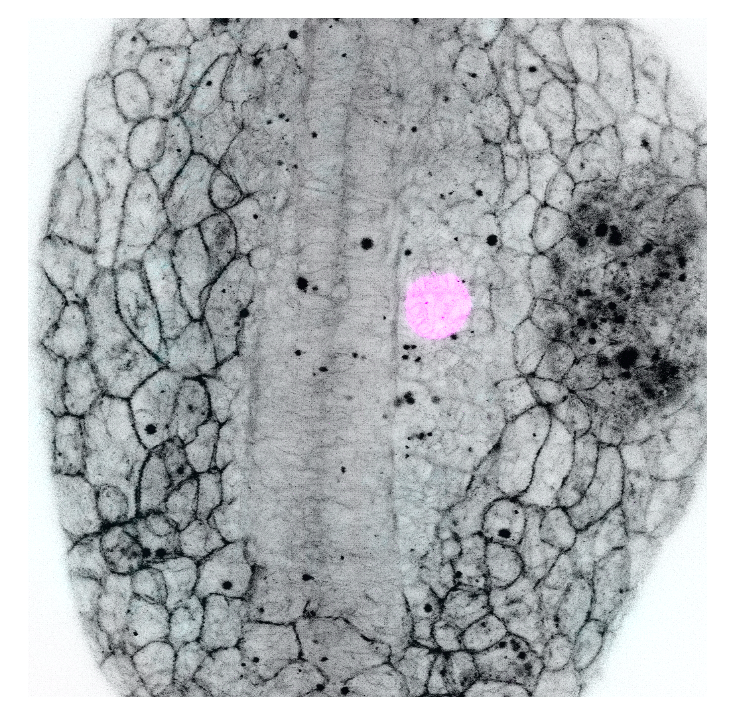

In [6]:
scale_native = [1, metadata.getPixelSizeZ(), metadata.getPixelSizeX(), metadata.getPixelSizeY()]
viewer.add_image(image[:, 0], name='membrane', colormap='gray_r', blending='translucent', scale=scale_native)
viewer.add_image(image[:, 1], name='droplet', colormap='magenta', blending='additive', scale=scale_native)
viewer.add_image(image[:, 2], name='other', colormap='cyan', blending='additive', scale=scale_native)
napari.utils.nbscreenshot(viewer, canvas_only=True)

### Data dimensions
You need to set a few parameters pertaining to your data:

In [7]:
voxel_size_x = metadata.getPixelSizeX()  # microns
voxel_size_y = metadata.getPixelSizeY()  # microns
voxel_size_z =metadata.getPixelSizeZ()   # microns
target_voxel_size = 2  # microns
time_step = 3  # minutes

## Analysis

We first put all parameters into a dictionary so we can save and reload them later. The parameters are explained here:
- [Reconstruction](toolboxes:droplet_reconstruction:interactive)
- [Measurement](toolboxes:stress_toolbox:stress_toolbox_interactive)

In [8]:
reconstruction_parameters = {
    'voxelsize': np.asarray([voxel_size_z, voxel_size_y, voxel_size_x]),
    'target_voxelsize': 2,
    'smoothing_sigma': 1,
    'n_smoothing_iterations': 15,
    'n_points': 256,
    'n_tracing_iterations': 2,
    'resampling_length': 1,
    'fit_type': 'fancy',
    'edge_type': 'interior',
    'trace_length': 10,
    'sampling_distance': 0.5,
    'interpolation_method':  'cubic',
    'outlier_tolerance': 1.5,
    'remove_outliers': True,
    'return_intermediate_results': True,
    'use_dask': True}

measurement_parameters = {
    'max_degree': 20,
    'n_quadrature_points': 5810,
    'gamma': 3.3,
    'use_dask': True}

We run the reconstruction and the stress analysis:

In [9]:
results_reconstruction = reconstruction.reconstruct_droplet(image[:, 1], **reconstruction_parameters)

Dask client up and running <Client: 'tcp://127.0.0.1:13121' processes=8 threads=40, memory=511.51 GiB>  Log: http://127.0.0.1:8787/status


In [10]:
_ = stress_backend.lbdv_info(Max_SPH_Deg=measurement_parameters['max_degree'],
                             Num_Quad_Pts=measurement_parameters['n_quadrature_points'])

results_stress_analysis = measurements.comprehensive_analysis(results_reconstruction[2][0], **measurement_parameters)

Dask client already running <Client: 'tcp://127.0.0.1:13121' processes=8 threads=40, memory=511.51 GiB>  Log: http://127.0.0.1:8787/status


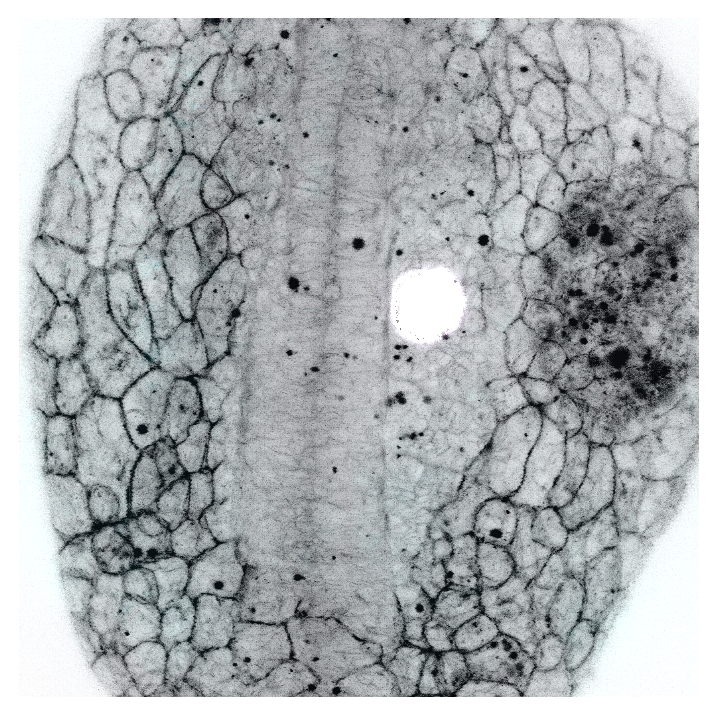

In [12]:
for res in results_reconstruction:
    layer = napari.layers.Layer.create(res[0], res[1], res[2])
    viewer.add_layer(layer)
napari.utils.nbscreenshot(viewer, canvas_only=True)

## Create paper screenshots and figures

In [13]:
viewer.layers['membrane'].depiction = 'volume'
viewer.layers['droplet'].depiction = 'volume'
viewer.layers['droplet'].blending = 'additive'
viewer.layers['other'].visible = False

We move the rendered plane to the center of mass of the droplet:

In [14]:
figure_directory = r'D:\Johannes\Nextcloud\Shared\Campaslab\projects\napari-stress-paper\documents\manuscript\figures\Figure7\imgs'
os.path.exists(figure_directory)

True

## Views on data

In [15]:
def set_timepoint(viewer, current_timepoint):
    # taken from https://github.com/haesleinhuepf/napari-time-slicer/blob/main/src/napari_time_slicer/_function.py
    variable_timepoint = list(viewer.dims.current_step)
    variable_timepoint[0] = current_timepoint
    viewer.dims.current_step = variable_timepoint

def make_layers_invisible(viewer):
    for layer in viewer.layers:
        layer.visible = False

In [16]:
timepoint = 10
set_timepoint(viewer, timepoint)
figure_quality = 2
viewer.scale_bar.visible = True
viewer.scale_bar.fixed_width = 50

## Plot settings

In [17]:
import matplotlib as mpl
# set matplotlib font to arial
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

# all spines 0.5pt
mpl.rcParams['axes.linewidth'] = 0.5

# all marker edge color black
mpl.rcParams['lines.markeredgewidth'] = 0.1
mpl.rcParams['lines.markersize'] = 0.5
mpl.rcParams['lines.markeredgecolor'] = 'black'

# tickmark line width
mpl.rcParams['xtick.major.width'] = 0.5
mpl.rcParams['ytick.major.width'] = 0.5

# set mm-to-inch conversion factor
cm = 1/2.54  # centimeters in inches
mm = cm/10  # millimeters in inches

# fontsize
fs = 5

## Reconstruction workflow

### 3D overview figure

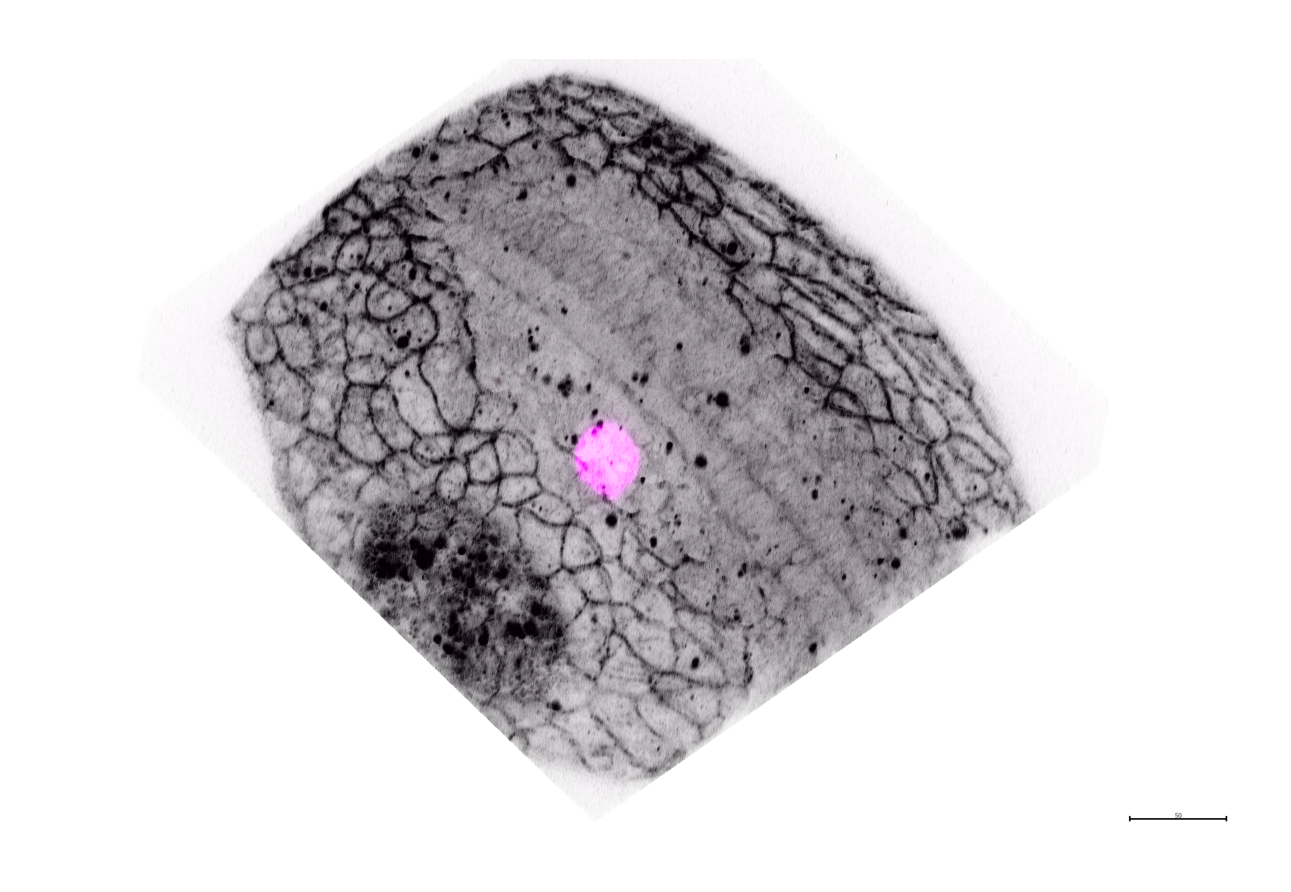

In [18]:
make_layers_invisible(viewer)

viewer.window.resize(1400, 800)
viewer.layers['membrane'].visible = True
viewer.layers['membrane'].depiction='volume'
viewer.layers['membrane'].blending = 'translucent'
viewer.layers['membrane'].rendering = 'mip'
viewer.layers['droplet'].visible = True
viewer.layers['droplet'].depiction='volume'
viewer.layers['droplet'].blending = 'additive'
viewer.layers['droplet'].rendering = 'mip'
viewer.camera.center = (28.0, 143.0, 192.0)
viewer.camera.zoom = 1.81
viewer.camera.angles = (-145, 26, 66)

viewer.scale_bar.visible = True

screenshot = viewer.screenshot(scale=2)

fig, ax = plt.subplots(figsize=(64*mm, 50*mm), dpi=600)
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_membranes_3D.png'), dpi=300, bbox_inches='tight')

### 2D closeup

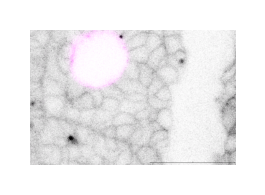

In [19]:
viewer.dims.ndisplay = 2
viewer.window.resize(1400, 800)
viewer.camera.center = (0, 173, 234)
viewer.camera.zoom = 9
viewer.camera.angles = (0, 0, 90)

viewer.layers['membrane'].blending = 'translucent'
viewer.layers['membrane'].depicion = 'plane'

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(25*mm, 25*mm), dpi=300)
ax.imshow(screenshot)
ax.axis('off')
fig.tight_layout()
fig.savefig(os.path.join(figure_directory, 'droplet_membranes_2D_2D.png'), dpi=300, bbox_inches='tight', pad_inches=0)

### Label image

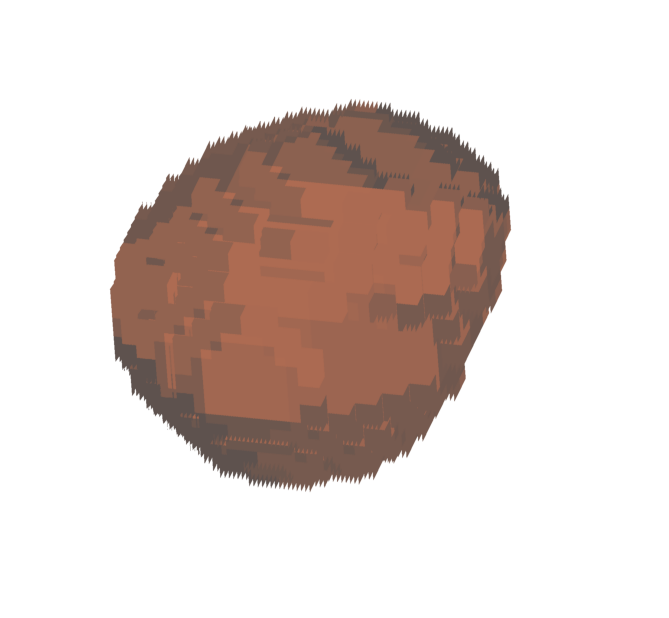

In [20]:
make_layers_invisible(viewer)
viewer.dims.ndisplay = 3
viewer.scale_bar.visible = False
viewer.layers['Label image'].visible = True

viewer.window.resize(1100, 800)
viewer.camera.center = (26.082624545584775, 162.6613044365564, 194.46992893145662)
viewer.camera.zoom = 16
viewer.camera.angles = (-116, 53, -25)

screenshot = viewer.screenshot(scale=figure_quality)

fig, ax = plt.subplots(figsize=(30*mm, 30*mm), dpi=600)
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_label.png'), dpi=500, bbox_inches='tight', pad_inches=0)


### First guess

In [21]:
def decimate_quadric(surface: 'napari.types.SurfaceData', number_of_vertices: int) -> 'napari.types.SurfaceData':
    # decimate the surface to a certain number of vertices
    mesh = vedo.Mesh((surface[0], surface[1]))
    mesh = mesh.decimate(number_of_vertices)
    return (mesh.vertices, np.array(mesh.cells, dtype=int))

def subdivide(surface: 'napari.types.SurfaceData', number_of_subdivisions: int) -> 'napari.types.SurfaceData':
    # subdivide the surface
    mesh = vedo.Mesh((surface[0], surface[1]))
    mesh = mesh.subdivide(number_of_subdivisions)
    return (mesh.vertices, np.array(mesh.cells, dtype=int))

def marching_cubes(data: "napari.types.LabelsData", level: float = 0.5) -> "napari.types.SurfaceData":
    vertices, faces, _, _ = measure.marching_cubes(data, level=level)
    return (vertices.astype(int), faces)

def smooth_surface(surface: "napari.types.SurfaceData", iterations: int = 15) -> "napari.types.SurfaceData":
    mesh = vedo.Mesh([surface[0].astype(int), surface[1]])
    mesh.smooth(niter=iterations, feature_angle=150)
    return (mesh.vertices, np.asarray(mesh.cells))

In [ ]:
make_layers_invisible(viewer)
surface = frame_by_frame(marching_cubes)(viewer.layers['Label image'].data)
surface_smooth = frame_by_frame(smooth_surface)(surface, 15)
surface_divided = frame_by_frame(subdivide)(surface_smooth, number_of_subdivisions=2)
viewer.add_surface(surface_divided, name='droplet surface subdivided', scale=[1, 2, 2, 2])
viewer.add_surface(surface_smooth, name='droplet surface', scale=[1, 2, 2, 2])

In [23]:
Converter = TimelapseConverter()
list_of_surfaces = Converter.data_to_list_of_data(surface_divided, layertype='napari.types.SurfaceData')

surface = list(list_of_surfaces[10])
surface[0] = surface[0] * 2
viewer.add_surface(surface)

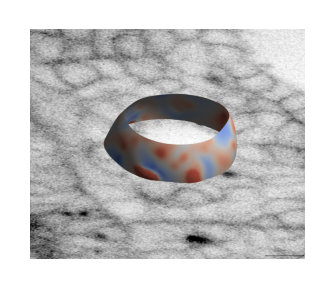

In [32]:
viewer.layers[-1].colormap = 'coolwarm'
viewer.layers[-1].contrast_limits = [0, 0.1]
viewer.scale_bar.visible = True
viewer.scale_bar.fixed_width = 10

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(30*mm, 30*mm), dpi=300)
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_surface_cut.png'), dpi=600, bbox_inches='tight', pad_inches=0)

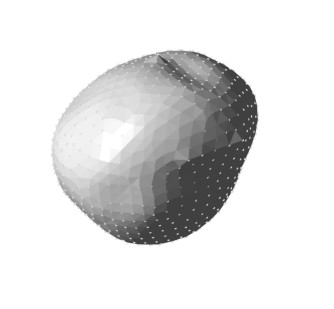

In [44]:
make_layers_invisible(viewer)
viewer.window.resize(1100, 800)
viewer.layers['droplet surface'].visible = True
viewer.layers['droplet surface points'].visible = True

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(30*mm, 30*mm), dpi=300)
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_first_guess.png'), dpi=600, bbox_inches='tight', pad_inches=0)

### Trace vectors

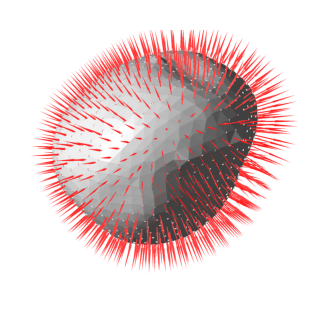

In [43]:
viewer.window.resize(1100, 800)
viewer.layers['Normals'].visible = True
viewer.layers['Normals'].edge_width = 0.2
viewer.layers['Normals'].length = 0.85
viewer.layers['Normals'].vector_style = 'arrow'

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(30*mm, 30*mm), dpi=300)
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_normals.png'), dpi=500, bbox_inches='tight', pad_inches=0)

### Reconstruction

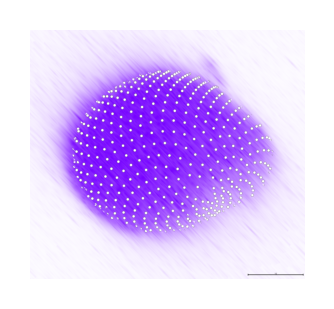

In [45]:
make_layers_invisible(viewer)
viewer.scale_bar.visible = True
viewer.scale_bar.fixed_width = 10
viewer.window.resize(1100, 800)
viewer.layers['droplet'].visible = True
viewer.layers['droplet'].depiction = 'volume'
viewer.layers['Droplet pointcloud (smoothed)'].visible = True
viewer.layers['droplet'].blending = 'translucent'
viewer.layers['droplet'].colormap = 'I Purple'

viewer.camera.center = (36, 150, 207)
viewer.camera.angles = (-50, 51, 87)

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(30*mm, 30*mm), dpi=300)
ax.imshow(screenshot)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, 'droplet_refined.png'), dpi=300, bbox_inches='tight', pad_inches=0)

#### Total stress

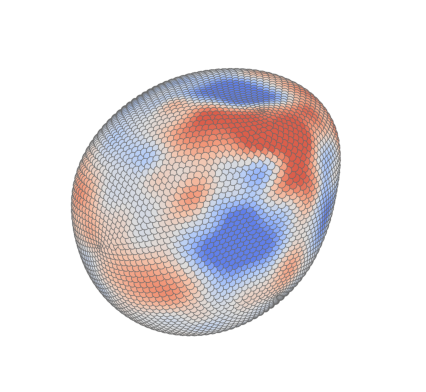

In [47]:
viewer.camera.angles = (-116, 53, -25)
viewer.camera.zoom = 18
viewer.camera.center = (29.15186330844246, 153.74747080708815, 208.32406186131644)
viewer.scale_bar.visible = False

make_layers_invisible(viewer)
viewer.window.resize(1100, 800)
viewer.layers['droplet'].blending = 'translucent'
viewer.layers['membrane'].visible = False
viewer.layers['Result of lebedev quadrature (droplet)'].visible = True
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = False

viewer.layers['Result of lebedev quadrature (droplet)'].blending = 'opaque'
viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_total'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-0.35, 0.35]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1

screenshot_total_stress = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(40*mm, 40*mm), dpi=300)
ax.imshow(screenshot_total_stress)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, "stress_total.png"), dpi=500, bbox_inches='tight', pad_inches=0)

#### Cell stress

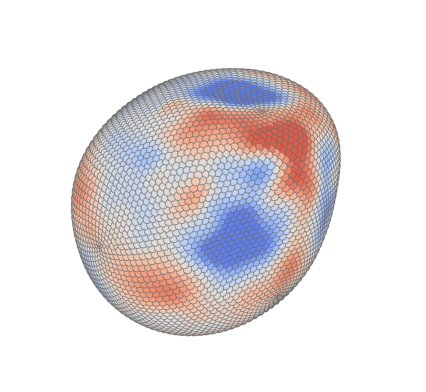

In [48]:
viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_cell'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].blending = 'opaque'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-0.35, 0.35]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1
viewer.window.resize(1100, 800)

screenshot_cell_stress = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(40*mm, 40*mm), dpi=300)
ax.imshow(screenshot_cell_stress)
ax.axis('off')
fig.savefig(os.path.join(figure_directory, "stress_cell.png"), dpi=500, bbox_inches='tight', pad_inches=0)

#### Tissue stress

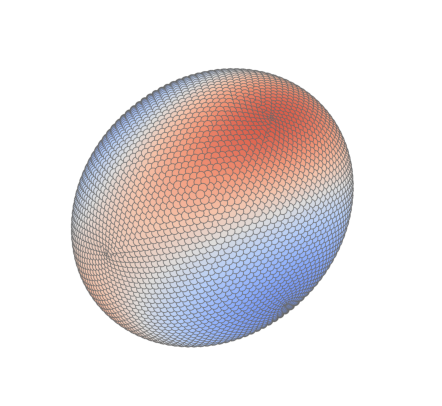

In [49]:
viewer.layers['Result of lebedev quadrature (droplet)'].visible = False
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = True
viewer.layers['Result of lebedev quadrature on ellipsoid'].face_color = 'stress_tissue'
viewer.layers['Result of lebedev quadrature on ellipsoid'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature on ellipsoid'].blending = 'opaque'
viewer.layers['Result of lebedev quadrature on ellipsoid'].face_contrast_limits = [-0.1, 0.1]
viewer.layers['Result of lebedev quadrature on ellipsoid'].refresh()
viewer.layers['Result of lebedev quadrature on ellipsoid'].size = 1
viewer.window.resize(1100, 800)

screenshot_tissue_stress = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(40*mm, 40*mm), dpi=300)
ax.imshow(screenshot_tissue_stress)
ax.axis('off')
fig.tight_layout()
fig.savefig(os.path.join(figure_directory, "stress_tissue.png"), dpi=500, bbox_inches='tight', pad_inches=0)

### Extremal stress 3D

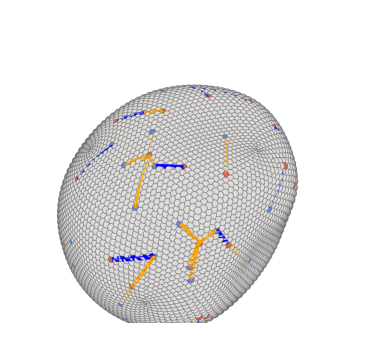

In [50]:
viewer.window.resize(1100, 800)
viewer.camera.center = (35, 155, 207)
viewer.camera.angles = (-70, 30, 16)
viewer.layers['Result of lebedev quadrature (droplet)'].visible = True
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = False
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1

viewer.layers['Total stress: Geodesics maxima -> nearest minima'].visible = True
viewer.layers['Total stress: Geodesics maxima -> nearest minima'].edge_width = 0.8
viewer.layers['Total stress: Geodesics maxima -> nearest minima'].blending = 'opaque'
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].visible = True
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].edge_width = 0.8
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].blending = 'opaque'
viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_total_extrema'
viewer.layers['Result of lebedev quadrature (droplet)'].blending = 'opaque'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-1, 1]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()

screenshot_nearest_extrema_3d = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(35*mm, 35*mm), dpi=300)
ax.imshow(screenshot_nearest_extrema_3d)
ax.axis('off')
fig.tight_layout()
fig.savefig(os.path.join(figure_directory, "droplet_nearest_extrema_3d.png"), dpi=500, bbox_inches='tight', pad_inches=0)

## Advanced visualizations

In this section, we create some advanced visualizations to highlight the interplay between the obtained measurements and their biological relevance.

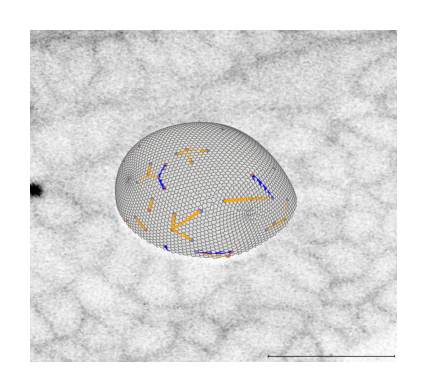

In [54]:
set_timepoint(viewer, 4)
viewer.camera.center = (35,147,209)
viewer.camera.angles = (-57, 40, 112)
viewer.camera.zoom = 11
viewer.scale_bar.visible = True
viewer.scale_bar.fixed_width = 25

viewer.layers['membrane'].visible = True
viewer.layers['membrane'].plane.position = (7.5, 443, 697)
viewer.layers['membrane'].rendering = 'additive'
viewer.layers['membrane'].depiction = 'plane'
viewer.layers['Result of lebedev quadrature (droplet)'].visible = True
viewer.layers['Result of lebedev quadrature on ellipsoid'].visible = False
viewer.layers['Result of lebedev quadrature (droplet)'].size = 1

viewer.layers['Total stress: Geodesics maxima -> nearest minima'].visible = True
viewer.layers['Total stress: Geodesics maxima -> nearest minima'].vector_style = 'line'
viewer.layers['Total stress: Geodesics maxima -> nearest minima'].edge_width = 0.8
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].visible = True
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].edge_width = 0.8
viewer.layers['Total stress: Geodesics minima -> nearest maxima'].vector_style = 'line'
viewer.layers['Result of lebedev quadrature (droplet)'].face_color = 'stress_total_extrema'
viewer.layers['Result of lebedev quadrature (droplet)'].face_colormap = 'coolwarm'
viewer.layers['Result of lebedev quadrature (droplet)'].face_contrast_limits = [-1, 1]
viewer.layers['Result of lebedev quadrature (droplet)'].refresh()

screenshot_nearest_extrema_3d = viewer.screenshot(scale=figure_quality)

fig, ax = plt.subplots(figsize=(40*mm, 40*mm), dpi=300)
ax.axis('off')
ax.imshow(screenshot_nearest_extrema_3d)
fig.savefig(os.path.join(figure_directory, "droplet_membrane_nearest_extrema_3d.png"), dpi=500, bbox_inches='tight', pad_inches=0)

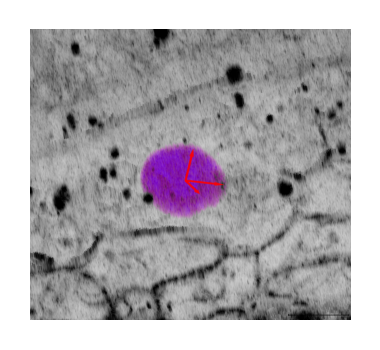

In [56]:
make_layers_invisible(viewer)
viewer.layers['membrane'].visible = True
viewer.layers['membrane'].depiction='volume'
viewer.layers['membrane'].blending = 'translucent'
viewer.layers['membrane'].rendering = 'mip'
viewer.layers['droplet'].visible = True
viewer.layers['droplet'].depiction='volume'
viewer.layers['droplet'].blending = 'minimum'
viewer.layers['droplet'].rendering = 'mip'

viewer.layers['membrane'].visible = True
viewer.layers['droplet'].visible = True
viewer.layers['membrane'].depiction = 'volume'
viewer.layers['droplet'].depiction = 'volume'
viewer.layers['fit_ellipsoid_to_pointcloud result'].visible = True
viewer.layers['fit_ellipsoid_to_pointcloud result'].vector_style = 'arrow'
viewer.layers['fit_ellipsoid_to_pointcloud result'].edge_width = 1.0
viewer.layers['fit_ellipsoid_to_pointcloud result'].blending = 'translucent_no_depth'

viewer.window.resize(1100, 800)
viewer.camera.center=(35.0, 147.0, 209.0)
viewer.camera.zoom=6
viewer.camera.angles=(-64.56521800938883, 31.49268860197681, 98.06097255964103)

screenshot = viewer.screenshot(scale=figure_quality)
fig, ax = plt.subplots(figsize=(35*mm, 35*mm), dpi=300)
ax.axis('off')
ax.imshow(screenshot)
fig.savefig(os.path.join(figure_directory, "major_axess_orientation.png"), dpi=300, bbox_inches='tight', pad_inches=0)

## Plots

In this section, we produce the plots for the figure in the paper that compare key results between the two implementations, namely: The total/cellular/tissue stresses, the spatial autocorrelations 

In [46]:
# Compile data
df_over_time, df_nearest_pairs, df_all_pairs, df_autocorrelations = utils.compile_data_from_layers(
    results_stress_analysis, n_frames=n_frames, time_step=time_step)

## Quantitative plots

In this section we create some quantitiative plots which demonstrate the match between the two implementations. Most noteably, we compare the total, cellular and tissue stress anisotropies as well as the spatial autocorrelation of the total stress.

In [47]:
#max_time = (image[:, :, 1].shape[0] - 1) * time_step
max_time = 60
ylims_stress = [-0.1, 0.65]

In [48]:
drop = viewer.layers['Result of lebedev quadrature on ellipsoid'].data
center = [drop[drop[:,0] == t].mean(axis=0) for t in np.arange(n_frames)]
radius = np.mean([np.sqrt(((drop[drop[:,0] == t] - center[t])**2).sum(axis=1)).mean() for t in np.arange(n_frames)])

## Stress anisotropies:

For total, cell & tissue stress, the Matlab-based implementation yields the following results:

![](./imgs/total_stress_anisotropy.jpg)
![](./imgs/cell_stress_anisotropy.jpg)
![](./imgs/tissue_stress_anisotropy.jpg)

...and these are the result of the napari-stress based implementation (note the different axis limits). As you can see, the results are very similar down to the second decimal place (~10kPa).

In [49]:
df_STRESS = pd.DataFrame()
for file in os.listdir('./results_STRESS/'):
    # read from file with data stored in row direction
    single_result = pd.read_csv(f'./results_STRESS/{file}', header=None).T

    column_name = file.split('.')[0]
    df_STRESS[column_name] = single_result.values.flatten()

to_compare = ['stress_total_anisotropy', 'stress_cell_anisotropy', 'stress_tissue_anisotropy']

for item in to_compare:
    difference_absolute = df_STRESS[item] - df_over_time[item]
    difference_relative = np.abs(difference_absolute) / df_over_time[item]

    df_over_time[f'{item}_difference_absolute'] = difference_absolute
    df_over_time[f'{item}_difference_relative'] = difference_relative

    print(f"Mean absolute difference for {item}: {difference_absolute.mean()} $\pm$ {difference_absolute.std()}")
    print(f"Mean relative difference for {item}: {difference_relative.mean()} $\pm$ {difference_relative.std()}")

Mean absolute difference for stress_total_anisotropy: 0.01471615428906991 $\pm$ 0.026013036408353413
Mean relative difference for stress_total_anisotropy: 0.04483832581735439 $\pm$ 0.0419828383966144
Mean absolute difference for stress_cell_anisotropy: 0.011845047924721793 $\pm$ 0.024976115952038407
Mean relative difference for stress_cell_anisotropy: 0.04533689384174737 $\pm$ 0.039536128889490846
Mean absolute difference for stress_tissue_anisotropy: 0.008569460469151512 $\pm$ 0.0035495001129169103
Mean relative difference for stress_tissue_anisotropy: 0.04268369789244 $\pm$ 0.016014770602567712


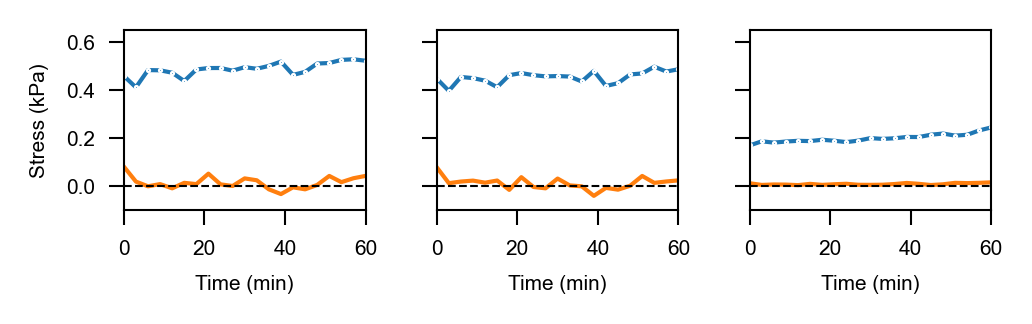

In [59]:
fig, axes = plt.subplots(ncols=3, figsize=(90*mm, 30*mm), dpi=300, sharex=True, sharey=True)
sns.lineplot(data=df_over_time, x='time', y='stress_total_anisotropy', ax=axes[0],
             markers=True, dashes=False, marker='o', markersize=0.5, linewidth=1)
sns.lineplot(data=df_over_time, x='time', y='stress_cell_anisotropy', ax=axes[1],
             markers=True, dashes=False, marker='o', markersize=0.5, linewidth=1)
sns.lineplot(data=df_over_time, x='time', y='stress_tissue_anisotropy', ax=axes[2],
             markers=True, dashes=False, marker='o', markersize=0.5, linewidth=1)

# abolsute differences
sns.lineplot(data=df_over_time, x='time', y='stress_total_anisotropy_difference_absolute', ax=axes[0], linewidth=1, markers='o', markersize=0.5)
sns.lineplot(data=df_over_time, x='time', y='stress_cell_anisotropy_difference_absolute', ax=axes[1], linewidth=1, markers='o', markersize=0.5)
sns.lineplot(data=df_over_time, x='time', y='stress_tissue_anisotropy_difference_absolute', ax=axes[2], linewidth=1, markers='o', markersize=0.5)

for ax in axes:
    ax.set_xlim([0,  max_time])
    ax.set_xlabel("Time (min)", fontsize=fs)
    ax.set_ylim(ylims_stress)
    ax.set_ylabel("Stress (kPa)", fontsize=5)

    ax.hlines(0, 0, max_time, color='black', linestyle='--', linewidth=0.5)

    # set fontsize of ticks
    ax.tick_params(axis='both', which='major', labelsize=fs)

fig.tight_layout()
fig.savefig(
    os.path.join(figure_directory, 'droplet_stress_anisotropy_all_over_time.pdf'),
    dpi=300,
    bbox_inches='tight')

## Spatial autocorrelations

The spatial autocorrelations for total and cellular stresses are reported as follows using the Matlab-based implementation:

![](./imgs/spatial_autocorrelation.jpg)

...and the napari-stress based implementation yields the following result for the total stress and cell stress:

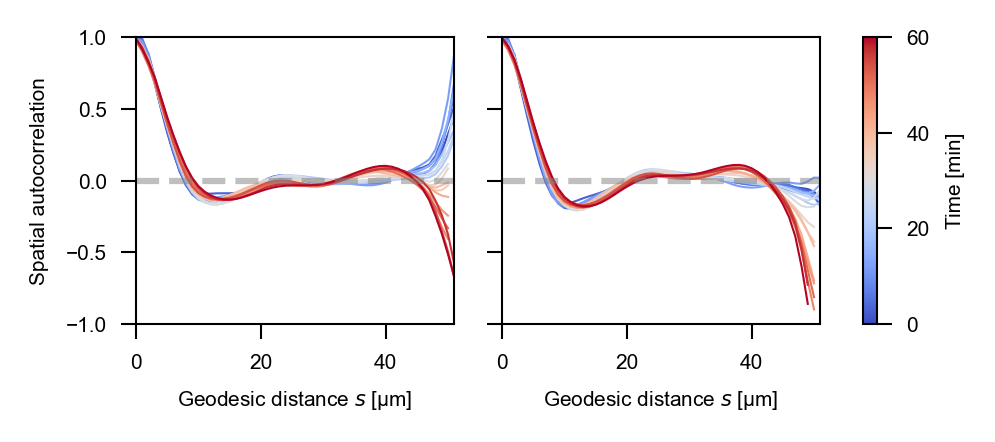

In [60]:
fig, axes = plt.subplots(ncols=2, figsize=(90*mm, 40*mm), dpi=300, sharex=True, sharey=True)

mappable = plt.cm.ScalarMappable(cmap='coolwarm', norm=plt.Normalize(vmin=0,
                                 vmax=df_autocorrelations.time.max()))

sns.lineplot(data=df_autocorrelations, x='distances', y='autocorrelations_spatial_total',
             hue='time', ax=axes[0], palette='coolwarm', legend=False, linewidth=0.5)

sns.lineplot(data=df_autocorrelations, x='distances', y='autocorrelations_spatial_cell',
             hue='time', ax=axes[1], palette='coolwarm', legend=False, linewidth=0.5)

for ax in axes:
    ax.set_xlabel("Geodesic distance $s$ [µm]", fontsize=fs)
    ax.set_ylabel("Spatial autocorrelation", fontsize=fs)

    ax.set_xlim([0,  df_autocorrelations['distances'].max()])
    ax.set_ylim([-1, 1])
    ax.hlines(0, 0, df_autocorrelations['distances'].max(), linestyle='--', color='gray',
              alpha=0.5)

    ax.tick_params(axis='both', which='major', labelsize=fs)

fig.tight_layout()
cbar = fig.colorbar(mappable, ax=np.asarray(fig.axes).ravel().tolist())
cbar.set_label('Time [min]', fontsize=fs)
cbar.set_ticklabels(cbar.get_ticks().astype(int), fontsize=fs)
fig.savefig(os.path.join(figure_directory, 'droplet_spatial_autocorrelation_total_cell.pdf'), dpi=300, bbox_inches='tight')

## Geodesic distances

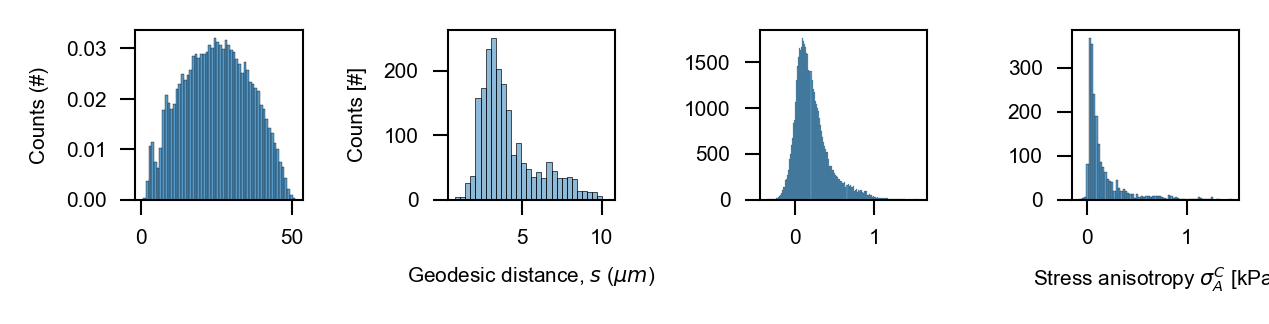

In [61]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(110*mm, 30*mm), dpi=300)
axes = axes.flatten()
sns.histplot(data=df_all_pairs, x='stress_cell_all_pair_distance', ax=axes[0], stat='density')
axes[0].set_xlabel("", fontsize=fs)
axes[0].set_ylabel("Counts (#)", fontsize=fs)


sns.histplot(data=df_nearest_pairs, x='stress_cell_nearest_pair_distance', ax=axes[1], alpha=0.5)
axes[1].set_xlabel("Geodesic distance, $s$ ($\mu m$)", fontsize=fs)
axes[1].set_ylabel("Counts [#]", fontsize=fs)

# Stress anisotropies (all pairs)
sns.histplot(data=df_all_pairs, x='stress_cell_all_pair_anisotropy', ax=axes[2])
axes[2].set_xlabel("", fontsize=fs)
axes[2].set_ylabel("", fontsize=fs)

# Stress anisotropies (nearest pairs)
sns.histplot(data=df_nearest_pairs, x='stress_cell_nearest_pair_anisotropy', ax=axes[3])
axes[3].set_xlabel("Stress anisotropy, $\sigma_A^C$ (kPa)", fontsize=fs)
axes[3].set_ylabel("", fontsize=fs)


for ax in axes:
    #ax.set_xlim([0,  df_all_pairs['stress_cell_all_pair_distance'].max()])
    ax.tick_params(axis='both', which='major', labelsize=fs)

fig.tight_layout()
fig.align_xlabels()
fig.savefig(os.path.join(figure_directory, 'spatial_autocorrelation_all_nearest_pair_distance.pdf'), dpi=300, bbox_inches='tight')

## Temporal autocorrelations

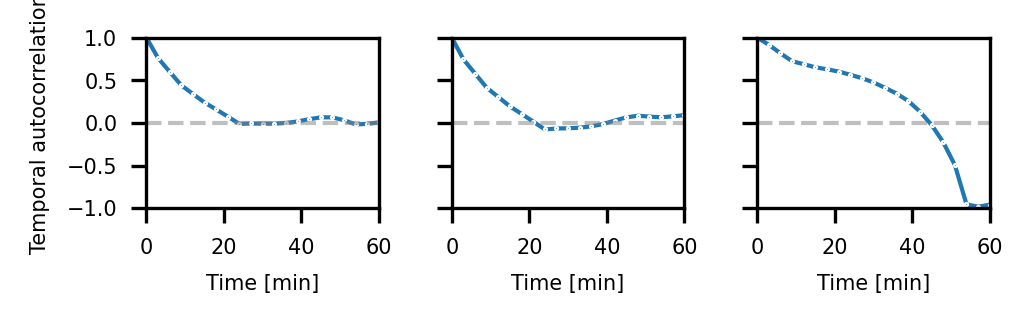

In [42]:
fig, axes = plt.subplots(ncols=3, figsize=(90*mm, 30*mm), dpi=300, sharex=True, sharey=True)
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_total', ax=axes[0], marker='o', markersize=.5, linewidth=1)
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_cell', ax=axes[1], marker='o', markersize=.5, linewidth=1)
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_tissue', ax=axes[2], marker='o', markersize=.5, linewidth=1)

for ax in axes:
    ax.set_xlim([0,  max_time])
    ax.set_ylim([-1, 1])
    ax.hlines(0, 0, max_time, linestyle='--', color='gray', alpha=0.5, linewidth=1)

    ax.set_xlabel("Time [min]", fontsize=fs)
    ax.set_ylabel("Temporal autocorrelation", fontsize=fs)
    ax.tick_params(axis='both', which='major', labelsize=fs)

fig.tight_layout()
fig.savefig(os.path.join(figure_directory, 'temporal_autocorrelation_all.pdf'), dpi=300, bbox_inches='tight')

## Composite figure

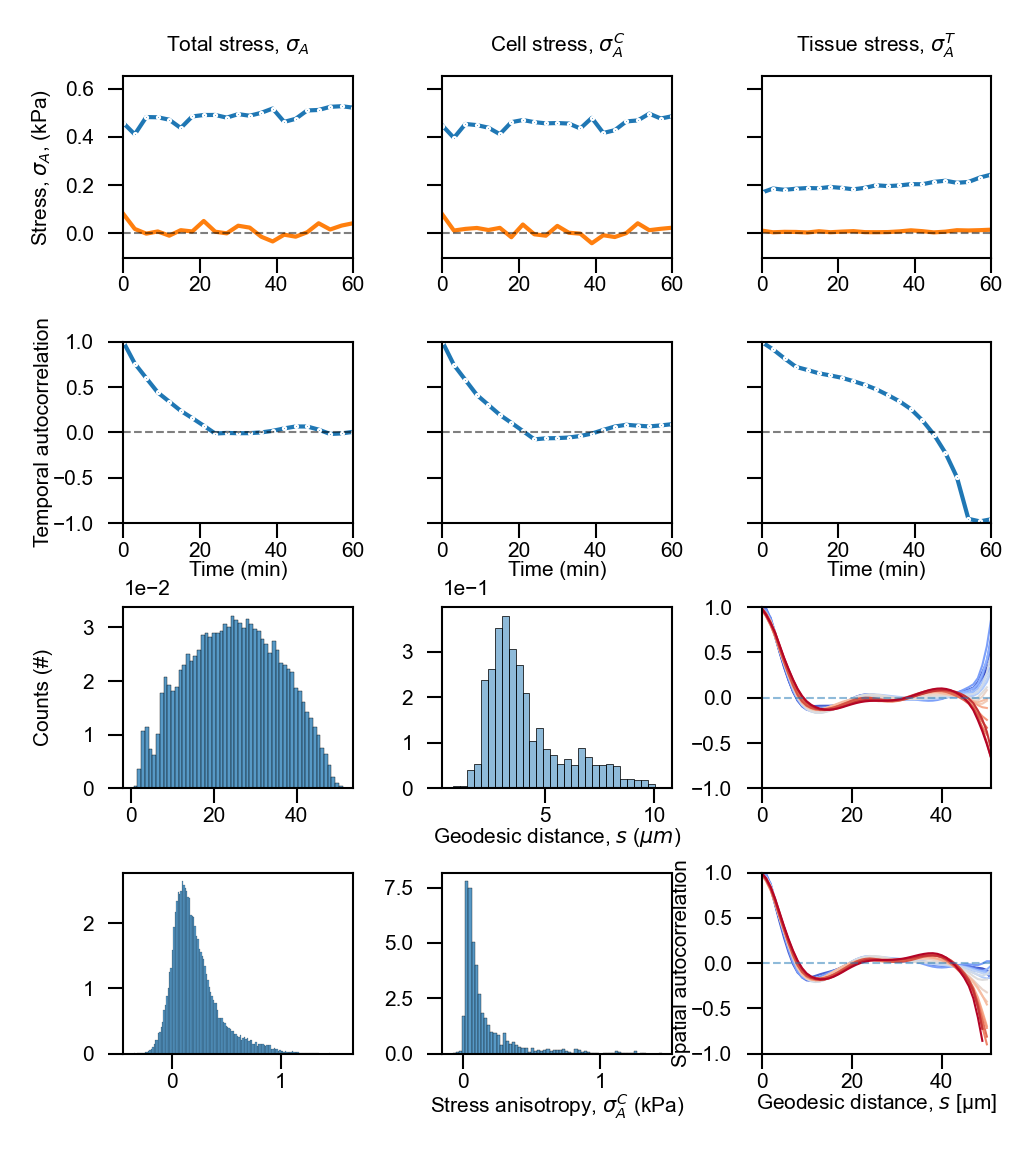

2024-07-26 10:34:45,003 - tornado.application - ERROR - Uncaught exception GET /status/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='127.0.0.1:8787', method='GET', uri='/status/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "c:\Users\Johannes\mambaforge\envs\stress\lib\site-packages\tornado\websocket.py", line 937, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
  File "c:\Users\Johannes\mambaforge\envs\stress\lib\site-packages\tornado\web.py", line 3290, in wrapper
    return method(self, *args, **kwargs)
  File "c:\Users\Johannes\mambaforge\envs\stress\lib\site-packages\bokeh\server\views\ws.py", line 149, in open
    raise ProtocolError("Token is expired.")
bokeh.protocol.exceptions.ProtocolError: Token is expired.


In [156]:
# set global labelpad and ticklabel padding
plt.rcParams['axes.labelpad'] = 0
plt.rcParams['xtick.major.pad'] = 1

# all fonts arial
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'

from matplotlib.ticker import ScalarFormatter

time_ticks = [0, 20, 40, 60]

fig, axes = plt.subplots(figsize=(90*mm, 100*mm), dpi=300, nrows=4, ncols=3)

# top row stresses
sns.lineplot(data=df_over_time, x='time', y='stress_total_anisotropy', ax=axes[0, 0],
             markers=True, dashes=False, marker='o', markersize=0.5, linewidth=1)
sns.lineplot(data=df_over_time, x='time', y='stress_cell_anisotropy', ax=axes[0, 1],
             markers=True, dashes=False, marker='o', markersize=0.5, linewidth=1)
sns.lineplot(data=df_over_time, x='time', y='stress_tissue_anisotropy', ax=axes[0, 2],
             markers=True, dashes=False, marker='o', markersize=0.5, linewidth=1)

# abolsute differences
sns.lineplot(data=df_over_time, x='time', y='stress_total_anisotropy_difference_absolute', ax=axes[0, 0], linewidth=1, markers='o', markersize=0.5)
sns.lineplot(data=df_over_time, x='time', y='stress_cell_anisotropy_difference_absolute', ax=axes[0, 1], linewidth=1, markers='o', markersize=0.5)
sns.lineplot(data=df_over_time, x='time', y='stress_tissue_anisotropy_difference_absolute', ax=axes[0, 2], linewidth=1, markers='o', markersize=0.5)

axes[0, 0].set_title("Total stress, $\sigma_A$", fontsize=fs)
axes[0, 1].set_title("Cell stress, $\sigma_A^C$", fontsize=fs)
axes[0, 2].set_title("Tissue stress, $\sigma_A^T$", fontsize=fs)

axes[0, 0].set_ylabel("Stress, $\sigma_A$, (kPa)", fontsize=fs)
axes[0, 1].set_ylabel(None, fontsize=fs)
axes[0, 2].set_ylabel(None, fontsize=fs)

# For first row, specifically
for idx, ax in enumerate(axes[0, :]):
    ax.set_xlim([0,  max_time])
    ax.set_ylim(ylims_stress)
    ax.hlines(0, 0, max_time, color='black', linestyle='--', linewidth=0.5, alpha=0.5)
    ax.set_xlabel(None)
    ax.set_xticks(time_ticks)

# Temporal autocorrelations
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_total', ax=axes[1, 0], marker='o', markersize=.5, linewidth=1)
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_cell', ax=axes[1, 1], marker='o', markersize=.5, linewidth=1)
sns.lineplot(df_over_time, x='time', y='autocorrelations_temporal_tissue', ax=axes[1, 2], marker='o', markersize=.5, linewidth=1)

for idx, ax in enumerate(axes[1, :]):
    ax.set_xlim([0,  max_time])
    ax.set_ylim([-1, 1])
    ax.hlines(0, 0, max_time, color='black', linestyle='--', linewidth=0.5, alpha=0.5)

    ax.set_xlabel("Time (min)", fontsize=fs)
    ax.set_ylabel("Temporal autocorrelation", fontsize=fs)

for ax in axes[:2, 1:].flatten():
    ax.set_yticklabels([])
    ax.set_ylabel(None)

# Spatial neighbors
sns.histplot(data=df_all_pairs, x='stress_cell_all_pair_distance', ax=axes[2, 0], stat='density')
axes[2, 0].set_xlabel("", fontsize=fs)
axes[2, 0].set_ylabel("Counts (#)", fontsize=fs)

sns.histplot(data=df_nearest_pairs, x='stress_cell_nearest_pair_distance', ax=axes[2, 1], alpha=0.5, stat='density')
axes[2, 1].set_xlabel("Geodesic distance, $s$ ($\mu m$)", fontsize=fs)
axes[2, 1].set_ylabel(None)

# use scientifc notation for y-axis tick labels (i.e., 1e-2)
for ax in axes[2:, :2].flatten():
    #ax.yaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))
    ax.yaxis.offsetText.set_fontsize(fs)

# Stress anisotropies (all pairs)
sns.histplot(data=df_all_pairs, x='stress_cell_all_pair_anisotropy', ax=axes[3, 0], stat='density')
axes[3, 0].set_xlabel(None)
axes[3, 0].set_ylabel(None)

# Stress anisotropies (nearest pairs)
sns.histplot(data=df_nearest_pairs, x='stress_cell_nearest_pair_anisotropy', ax=axes[3, 1], stat='density')
axes[3, 1].set_xlabel("Stress anisotropy, $\sigma_A^C$ (kPa)", fontsize=fs)
axes[3, 1].set_ylabel(None, fontsize=fs)

# Spatial autocorrelations
sns.lineplot(data=df_autocorrelations, x='distances', y='autocorrelations_spatial_total',
             hue='time', ax=axes[2, 2], palette='coolwarm', legend=False, linewidth=0.5)

sns.lineplot(data=df_autocorrelations, x='distances', y='autocorrelations_spatial_cell',
             hue='time', ax=axes[3, 2], palette='coolwarm', legend=False, linewidth=0.5)


axes[2, 2].set_ylabel(None)
axes[2, 2].set_xlabel(None)
axes[3, 2].set_ylabel("Spatial autocorrelation", fontsize=fs)
axes[3, 2].set_xlabel("Geodesic distance, $s$ (µm)", fontsize=fs)

for ax in axes[2:, 2].flatten():
    ax.set_xlim([0,  df_autocorrelations['distances'].max()])
    ax.set_ylim([-1, 1])
    ax.hlines(0, 0, df_autocorrelations['distances'].max(), linestyle='--', linewidth=0.5, alpha=0.5)

# For all axes
for ax in axes.flatten():
    #ax.set_xlabel("Time [min]", fontsize=fs)
    #ax.set_ylabel("Temporal autocorrelation", fontsize=fs)
    ax.tick_params(axis='both', which='major', labelsize=fs)
    

fig.align_ylabels()

fig.tight_layout(h_pad=0.0, w_pad=0.0)
fig.align_ylabels()
fig.savefig(os.path.join(figure_directory, 'droplet_all.pdf'), dpi=300, bbox_inches='tight')